# Part 0
## 0.1

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import viser
import matplotlib.pyplot as plt
import imageio
import random

In [ ]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, detector_params)

tag_size = 0.055 / 2

# object_points_single = np.array([
#     [0,  0, 0],
#     [0,  tag_size, 0],
#     [ tag_size, 0, 0],
#     [tag_size, tag_size, 0],
# ], dtype=np.float32)

object_points_single = np.array([
    [-tag_size,  tag_size, 0],
    [ tag_size,  tag_size, 0],
    [ tag_size, -tag_size, 0],
    [-tag_size, -tag_size, 0],
], dtype=np.float32)

object_points = []
image_points = []

calibration_folder = "calibration_plz"

for filename in os.listdir(calibration_folder):
    if filename.startswith('.'):
        continue

    image_path = os.path.join(calibration_folder, filename)
    image = cv2.imread(image_path)
    
    corners, ids, _ = detector.detectMarkers(image)
    
    if ids is not None and len(corners) > 0:
        for i, corner in enumerate(corners):
            image_points.append(corner.reshape(-1, 2))
            object_points.append(object_points_single)

if len(image_points) > 0:
    image_height, image_width = image.shape[:2]
    ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points, image_points, (image_width, image_height), None, None)
    
    print(f"Camera matrix:\n{camera_matrix}")
    print(f"Distortion coefficients: {distortion_coeffs.flatten()}")

Camera matrix:
[[1.05108362e+03 0.00000000e+00 5.53870682e+02]
 [0.00000000e+00 1.11699005e+03 4.81941158e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients: [ 0.0279701  -0.43890901  0.02117612  0.00373373  0.76379661]


## 0.3

In [ ]:
images_folder = "part0.2_images"

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, detector_params)

object_points_3d = np.array([
    [-tag_size,  tag_size, 0],
    [ tag_size,  tag_size, 0],
    [ tag_size, -tag_size, 0],
    [-tag_size, -tag_size, 0],
], dtype=np.float32)

camera_poses = []
valid_images = []

for i, filename in enumerate(sorted(os.listdir(images_folder))):
    image_path = os.path.join(images_folder, filename)
    image = cv2.imread(image_path)
    corners, ids, _ = detector.detectMarkers(image)
    
    if ids is not None and len(corners) > 0:
        id = 0
        flat_id = ids.flatten()
        if id not in flat_id:
            continue

        idx = np.where(flat_id == id)[0][0]
        image_points_2d = corners[idx].reshape(-1, 2).astype(np.float32)

        success, rvec, tvec = cv2.solvePnP(
            object_points_3d, 
            image_points_2d, 
            camera_matrix, 
            distortion_coeffs
        )

        if not success:
            continue

        R, _ = cv2.Rodrigues(rvec)
        t = tvec.reshape(3)

        T_w2c = np.eye(4, dtype=np.float32)
        T_w2c[:3, :3] = R
        T_w2c[:3, 3] = t

        T_c2w = np.linalg.inv(T_w2c)        

        camera_poses.append(T_c2w)
        valid_images.append((image, filename, i))

In [288]:
server = viser.ViserServer(share=True)
H, W = image.shape[:2]
for i, ((img, filename, img_idx), c2w) in enumerate(zip(valid_images, camera_poses)):
    server.scene.add_camera_frustum(
        f"/cameras/{img_idx}_{filename}",
        fov=2 * np.arctan2(W / 2, camera_matrix[0, 0]), # Use Width
        aspect=W / H,
        scale=0.01,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
print("Viser server running. Check the link!")

╭────── viser (listening *:8099) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8099   │
│   Websocket │ ws://localhost:8099     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://loop-simulated.share.viser.studio

Viser server running. Check the link!


## 0.4

In [ ]:
focal = float(camera_matrix[0, 0])

undistorted = []
poses = []

h, w = valid_images[0][0].shape[:2]
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
    camera_matrix,
    distortion_coeffs,
    (w, h),
    alpha=0.0,
    newImgSize=(w, h)
)

x, y, w_roi, h_roi = roi

for i, (img, filename, img_idx) in enumerate(valid_images):

    undistorted_img = cv2.undistort(
        img,
        camera_matrix,
        distortion_coeffs,
        None,
        new_camera_matrix
    )

    undistorted_img = undistorted_img[y:y + h_roi, x:x + w_roi]
    undistorted_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted.append(undistorted_rgb)
    poses.append(camera_poses[i])

undistorted = np.array(undistorted)
poses = np.array(poses)

new_camera_matrix[0, 2] -= x
new_camera_matrix[1, 2] -= y

focal = float(new_camera_matrix[0, 0])
n_images = len(undistorted)
n_train = int(0.7 * n_images)
n_val = int(0.15 * n_images)
n_test = n_images - n_train - n_val

indices = np.arange(n_images)
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

images_train = undistorted[train_indices]
c2ws_train = poses[train_indices]

images_val = undistorted[val_indices]
c2ws_val = poses[val_indices]

c2ws_test = poses[test_indices]

dataset_filename = "vaja.npz"

np.savez(
    dataset_filename,
    images_train=images_train,
    c2ws_train=c2ws_train,
    images_val=images_val,
    c2ws_val=c2ws_val,
    c2ws_test=c2ws_test,
    focal=focal,
    K=new_camera_matrix,
    c2ws_all_ordered=poses
)

print("Saved dataset:", dataset_filename)

# Part 1

In [ ]:
class NeRF(nn.Module):
    def __init__(self, num_freqs=10, dims=2, hidden_dims=256):
        super(NeRF, self).__init__()
        self.fc1 = nn.Linear(num_freqs * dims * 2 + dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs=10):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs
        self.powers = 2 ** torch.linspace(0, num_freqs - 1, num_freqs)

    def forward(self, x):
        pe = [x]
        for freq in self.powers:
            pe.append(torch.sin(freq * torch.pi * x))
            pe.append(torch.cos(freq * torch.pi * x))
        pe = torch.cat(pe, dim=-1)
        return pe

class ImageDataset(Dataset):
    def __init__(self, image, samples_epoch):

        super().__init__()
        self.h, self.w = image.shape[:2]
        self.image = torch.from_numpy(image).float() / 255.0
        self.samples_epoch = samples_epoch

    def __len__(self):
        return self.samples_epoch

    def __getitem__(self, idx):
        x = torch.randint(0, self.w, (1,)).item()
        y = torch.randint(0, self.h, (1,)).item()

        coord = torch.tensor([x / self.w, y / self.h], dtype=torch.float32)
        color = self.image[y, x, :]
        return coord, color
        
    def get_size(self):
        return self.h, self.w

In [50]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
image_path = "messi.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
samples_epoch = 10000
image_dataset = ImageDataset(image, samples_epoch)
h, w = image_dataset.get_size()
epochs = 3000
x, y = torch.meshgrid(
    torch.linspace(0, 1, w),
    torch.linspace(0, 1, h),
    indexing='xy'
)
L = 10
dims = 2
hidden_dims = 256
checkpoints = [0, 100, 200, 400, 1600, 2999]
coords = torch.stack([x, y], dim=-1).reshape(-1, 2)
encodings = PositionalEncoding(L).to(device)
image_dataloader = DataLoader(image_dataset, batch_size=10000, shuffle=True)
criterion = torch.nn.MSELoss()

model = NeRF(L, dims, hidden_dims).to(device)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if L == 10 and hidden_dims == 256:
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("plots", exist_ok=True)

mse = []
psnr = []
for epoch in range(epochs):
    for i, (coordinates, norm_pixels) in enumerate(image_dataloader):
        coordinates = coordinates.to(device)
        norm_pixels = norm_pixels.to(device)
        optimizer.zero_grad()
        pe = encodings(coordinates)
        model_output = model(pe)
        loss = criterion(model_output, norm_pixels)
        loss.backward()
        optimizer.step()

    mse.append(loss.item())
    psnr.append(10 * np.log10(1 / loss.item()))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
    if L == 10 and hidden_dims == 256 and epoch in checkpoints:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pth")

if L == 10 and hidden_dims == 256:
    plt.figure(figsize=(8,5))
    plt.plot(mse, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/loss_curve.png")
    plt.close()

    plt.figure(figsize=(8,5))
    plt.plot(psnr, label='Training PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Training PSNR Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/psnr_curve.png")
    plt.close()

Epoch 0, Loss 0.058060
Epoch 100, Loss 0.010129
Epoch 200, Loss 0.005783
Epoch 300, Loss 0.004681
Epoch 400, Loss 0.004365
Epoch 500, Loss 0.003780
Epoch 600, Loss 0.003547
Epoch 700, Loss 0.003543
Epoch 800, Loss 0.003507
Epoch 900, Loss 0.003036
Epoch 1000, Loss 0.003287
Epoch 1100, Loss 0.002980
Epoch 1200, Loss 0.002890
Epoch 1300, Loss 0.002935
Epoch 1400, Loss 0.002747
Epoch 1500, Loss 0.002767
Epoch 1600, Loss 0.002625
Epoch 1700, Loss 0.002682
Epoch 1800, Loss 0.002768
Epoch 1900, Loss 0.002407
Epoch 2000, Loss 0.002549
Epoch 2100, Loss 0.002694
Epoch 2200, Loss 0.002589
Epoch 2300, Loss 0.002509
Epoch 2400, Loss 0.002354
Epoch 2500, Loss 0.002253
Epoch 2600, Loss 0.002184
Epoch 2700, Loss 0.002437
Epoch 2800, Loss 0.002257
Epoch 2900, Loss 0.002344


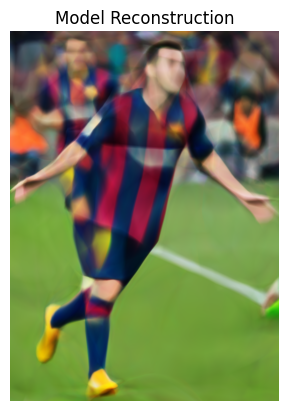

In [ ]:
model.eval()
h, w = image_dataset.h, image_dataset.w

x = torch.linspace(0, 1, w)
y = torch.linspace(0, 1, h)
yy, xx = torch.meshgrid(y, x, indexing='ij')
coords = torch.stack([xx, yy], dim=-1).view(-1, 2).to(device)

preds = []
batch_size = 10000
with torch.no_grad():
    for i in range(0, coords.shape[0], batch_size):
        encoded = encodings(coords[i:i+batch_size])
        pred = model(encoded)
        preds.append(pred.cpu())
preds = torch.cat(preds, dim=0)

reconstructed = preds.view(h, w, 3).numpy()

plt.imshow(reconstructed)
plt.axis('off')
plt.title('Model Reconstruction')
plt.savefig(f"messi_reconstruction_L{L}_W{hidden_dims}.png", bbox_inches='tight', dpi=300)
plt.show()

In [51]:
import torch
import matplotlib.pyplot as plt
import glob
import os

# ---- CONFIG ----
checkpoint_files = sorted(glob.glob("checkpoint_epoch_*.pth"))
output_folder = "reconstructions"
os.makedirs(output_folder, exist_ok=True)

# Build full coordinate grid
h, w = image_dataset.h, image_dataset.w
x = torch.linspace(0, 1, w)
y = torch.linspace(0, 1, h)
yy, xx = torch.meshgrid(y, x, indexing='ij')
coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2).to(device)

# ---- LOOP THROUGH CHECKPOINTS ----
for ckpt_path in checkpoint_files:
    print(f"\nLoading checkpoint: {ckpt_path}")

    # Extract the epoch number (e.g., "checkpoint_epoch_400.pth" → "400")
    epoch = ckpt_path.split("_")[-1].split(".")[0]

    # Load model
    model = NeRF(L, dims, hidden_dims).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    preds = []
    batch_size = 10000

    with torch.no_grad():
        for i in range(0, coords.shape[0], batch_size):
            encoded = encodings(coords[i:i+batch_size])
            pred = model(encoded)
            preds.append(pred.cpu())

    preds = torch.cat(preds, dim=0)
    reconstructed = preds.view(h, w, 3).numpy()

    # Save image
    save_path = os.path.join(output_folder, f"reconstruction_epoch_{epoch}.png")
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.title(f"Reconstruction @ Epoch {epoch}")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Saved → {save_path}")



Loading checkpoint: checkpoint_epoch_0.pth
Saved → reconstructions/reconstruction_epoch_0.png

Loading checkpoint: checkpoint_epoch_100.pth
Saved → reconstructions/reconstruction_epoch_100.png

Loading checkpoint: checkpoint_epoch_1600.pth
Saved → reconstructions/reconstruction_epoch_1600.png

Loading checkpoint: checkpoint_epoch_200.pth
Saved → reconstructions/reconstruction_epoch_200.png

Loading checkpoint: checkpoint_epoch_2999.pth
Saved → reconstructions/reconstruction_epoch_2999.png

Loading checkpoint: checkpoint_epoch_400.pth
Saved → reconstructions/reconstruction_epoch_400.png


# Part 2

In [273]:
# parse data
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

## 2.1

In [ ]:
def transform(c2w, x_c):
    B, H, W, coord_size = x_c.shape
    device = x_c.device
    x_c = torch.cat([x_c, torch.ones(B, H, W, 1, device=device)], dim=-1)
    x_c = x_c.view(B, H * W, coord_size + 1)
    x_w = torch.bmm(c2w, x_c.transpose(1, 2))
    x_w = x_w.transpose(1, 2)
    x_w = x_w[:, :, :coord_size]
    x_w = x_w.view(B, H, W, coord_size)
    return x_w

def pixel_to_camera(K, uv, s):
    device = uv.device
    B, H, W, coord_size = uv.shape
    uv = torch.cat([uv, torch.ones(B, H, W, 1, device=device)], dim=-1)
    uv = uv.view(B, H * W, coord_size + 1)
    K_inv = torch.inverse(K)
    x_c = torch.bmm(uv, K_inv.transpose(1, 2))
    x_c = x_c.view(B, H, W, coord_size + 1)
    x_c = x_c * s
    return x_c

def pixel_to_ray(K, c2w, uv):
    B, _, _, _ = uv.shape
    r_o = c2w[:, :3, 3]
    r_o = r_o.view(B, 1, 1, 3)
    x_c = pixel_to_camera(K, uv, 1.0)
    x_w = transform(c2w, x_c)
    r_d = x_w - r_o
    r_d = F.normalize(r_d, p=2, dim=-1)
    return r_o, r_d

## 2.2

In [ ]:
def sample_rays_global(images, K, c2ws, N):
    B, H, W, _ = images.shape
    device = images.device

    sampled_rays = torch.randint(0, B * H * W, (N,), device=device)
    image = sampled_rays // (H * W)
    uv = sampled_rays % (H * W)
    h_indices = uv // W
    w_indices = uv % W

    sampled_k = K[image]
    sampled_c2w = c2ws[image]
    colors = images[image, h_indices, w_indices]
    u = w_indices.float() + 0.5
    v = h_indices.float() + 0.5
    uv = torch.stack([u, v], dim=-1)
    uv = uv.view(N, 1, 1, 2)
    r_o, r_d = pixel_to_ray(sampled_k, sampled_c2w, uv)
    r_o = r_o.squeeze(1).squeeze(1)
    r_d = r_d.squeeze(1).squeeze(1)
    return r_o, r_d, colors

def sample_along_rays(rays_o, rays_d, n_samples, near, far, perturb):
    N_rays = rays_o.shape[0]
    device = rays_o.device

    if perturb:
        width = (far - near) / n_samples
        t_1 = near + torch.arange(0, n_samples, device=device) * width
        rands = torch.rand(N_rays, n_samples, device=device)
        t = t_1.unsqueeze(0) + rands * width
    else:
        t_1 = torch.linspace(near, far, n_samples, device=device)
        t = t_1.expand(N_rays, n_samples)

    r_o = rays_o.unsqueeze(1)
    r_d = rays_d.unsqueeze(1)
    t_vals = t.unsqueeze(2)
    points = r_o + t_vals * r_d
    return points

## 2.3

In [ ]:
class RaysData:
    def __init__(self, images, K, c2ws):
        self.images = images
        self.K = K
        self.c2ws = c2ws
        self.B, self.H, self.W, _ = images.shape
        device = images.device
        
        u, v = torch.meshgrid(
            torch.arange(self.W, device=device),
            torch.arange(self.H, device=device),
            indexing='xy'
        ) 
        
        grid = torch.stack([u, v], dim=-1)
        uvs = grid.unsqueeze(0).expand(self.B, -1, -1, -1)
        uv_grid = grid.float() + 0.5
        self.uvs_full = uv_grid.unsqueeze(0).expand(self.B, -1, -1, -1)
        self.K = self.K.to(device)
        self.c2ws = self.c2ws.to(device)
        rays_o, rays_d = pixel_to_ray(self.K, self.c2ws, self.uvs_full)
        rays_o = rays_o.expand(-1, self.H, self.W, -1)
        self.rays_o = rays_o.reshape(-1, 3) 
        self.rays_d = rays_d.reshape(-1, 3) 
        self.pixels = self.images.reshape(-1, 3)
        self.uvs = uvs.reshape(-1, 2)

    def sample_rays(self, N):
        return sample_rays_global(self.images, self.K, self.c2ws, N)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images_train_t = torch.tensor(images_train, device=device, dtype=torch.float32)
c2ws_train_t = torch.tensor(c2ws_train, device=device, dtype=torch.float32)

H, W = images_train_t.shape[1:3]

K_np = np.array([
    [focal, 0, W/2],
    [0, focal, H/2],
    [0, 0, 1]
], dtype=np.float32)

K_t = torch.tensor(K_np, device=device)

B = images_train_t.shape[0]
K_t_batched = K_t.unsqueeze(0).expand(B, 3, 3)
dataset = RaysData(images_train_t, K_t_batched, c2ws_train_t)
rays_o, rays_d, pixels = dataset.sample_rays(100)
points = sample_along_rays(rays_o, rays_d, 64, 2, 6, True)

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train_t.numpy(), c2ws_train_t.numpy())):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K_t[0, 0].numpy()),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )

rays_o_np = rays_o.numpy()
rays_d_np = rays_d.numpy()
points_np = points.numpy()

for i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.02,
)

╭────── viser (listening *:8097) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8097   │
│   Websocket │ ws://localhost:8097     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://shape-mapping.share.viser.studio

/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/1305130500.py:28: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/1305130500.py:43: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/1305130500.py:46: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


PointCloudHandle(points=array([[ 0.3774,  1.881 ,  1.189 ],
       [ 0.4097,  1.836 ,  1.13  ],
       [ 0.4363,  1.799 ,  1.08  ],
       ...,
       [ 1.205 , -1.239 , -1.446 ],
       [ 1.221 , -1.288 , -1.467 ],
       [ 1.241 , -1.354 , -1.495 ]], dtype=float16), colors=array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8), point_size=0.02, point_shape='square', precision='float16')

(viser) Connection opened (0, 1 total), 608 persistent messages

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images_train_t = torch.tensor(images_train, device=device, dtype=torch.float32)
c2ws_train_t = torch.tensor(c2ws_train, device=device, dtype=torch.float32)

H, W = images_train_t.shape[1:3]
B = images_train_t.shape[0]

K_np = np.array([
    [focal, 0, W/2],
    [0, focal, H/2],
    [0, 0, 1]
], dtype=np.float32)

K_t = torch.tensor(K_np, device=device)
K_t_batched = K_t.unsqueeze(0).expand(B, 3, 3)
dataset = RaysData(images_train_t, K_t_batched, c2ws_train_t)
uvs_start = 0
uvs_end = H * W
sample_uvs = dataset.uvs[uvs_start:uvs_end].numpy()

assert np.allclose(
    images_train[0, sample_uvs[:, 1], sample_uvs[:, 0]], 
    dataset.pixels[uvs_start:uvs_end].numpy()
), "Assertion Failed: Pixels and UVs do not match."

indices = torch.randint(low=0, high=H * W, size=(100,), device=device)

# # Uncomment this to display random rays from the top left corner of the FIRST image
# indices_x = torch.randint(low=100, high=200, size=(100,), device=device)
# indices_y = torch.randint(low=0, high=100, size=(100,), device=device)
# indices = indices_x + (indices_y * W) # Use W, not 200

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points_t = sample_along_rays(data["rays_o"], data["rays_d"], 64, 2, 6, True)
rays_o_np = data["rays_o"].numpy()
rays_d_np = data["rays_d"].numpy()
points_np = points_t.numpy()
server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K_np[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )

for i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )

server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.03,
)

╭────── viser (listening *:8098) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8098   │
│   Websocket │ ws://localhost:8098     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://stiff-invisible.share.viser.studio

/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/261899615.py:41: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/261899615.py:53: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/var/folders/p3/gs81flw93s72f61ch8sx0k780000gn/T/ipykernel_34862/261899615.py:57: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


PointCloudHandle(points=array([[-0.1102  ,  2.178   ,  0.08527 ],
       [-0.1127  ,  2.105   ,  0.03607 ],
       [-0.115   ,  2.037   , -0.009895],
       ...,
       [ 1.517   , -1.619   , -0.1638  ],
       [ 1.533   , -1.679   , -0.1786  ],
       [ 1.551   , -1.737   , -0.1934  ]], dtype=float16), colors=array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8), point_size=0.03, point_shape='square', precision='float16')

(viser) Connection opened (0, 1 total), 608 persistent messages

## 2.4

In [282]:
class NeuralRadianceField(nn.Module):
    def __init__(self, coord_freqs=10, dir_freqs=4, dims=3, hidden_dims=256):
        super(NeuralRadianceField, self).__init__()
        self.coordinate_dims = coord_freqs * dims * 2 + dims
        self.ray_dims = dir_freqs * dims * 2 + dims
        self.fc1 = nn.Linear(self.coordinate_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims + self.coordinate_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.fc8 = nn.Linear(hidden_dims, hidden_dims)

        self.density_fc = nn.Linear(hidden_dims, 1)
        self.rgb_fc1 = nn.Linear(hidden_dims, hidden_dims)
        self.rgb_fc2 = nn.Linear(hidden_dims + self.ray_dims, hidden_dims // 2)
        self.rgb_fc3 = nn.Linear(hidden_dims // 2, 3)

    def forward(self, x, r_d):
        x_nn = torch.relu(self.fc1(x))
        x_nn = torch.relu(self.fc2(x_nn))
        x_nn = torch.relu(self.fc3(x_nn))
        x_nn = torch.relu(self.fc4(x_nn))
        x_nn = torch.cat([x_nn, x], dim=-1)
        x_nn = torch.relu(self.fc5(x_nn))
        x_nn = torch.relu(self.fc6(x_nn))
        x_nn = torch.relu(self.fc7(x_nn))
        x_nn = self.fc8(x_nn)

        x_density = torch.relu(self.density_fc(x_nn))
        x_rgb = self.rgb_fc1(x_nn)
        x_rgb = torch.cat([x_rgb, r_d], dim=-1)
        x_rgb = torch.relu(self.rgb_fc2(x_rgb))
        x_rgb = torch.sigmoid(self.rgb_fc3(x_rgb))
        return x_density, x_rgb

## 2.5

In [283]:
def volrend(sigmas, rgbs, step_size):
    alphas = 1 - torch.exp(-sigmas * step_size)
    summation = torch.cumsum(sigmas * step_size, dim=1)
    T_i = torch.exp(-(summation - sigmas * step_size))
    weights = T_i * alphas
    colors = torch.sum(weights * rgbs, dim=1)
    return colors

In [ ]:
def get_all_rays(h, w, k, c2w):
    device = c2w.device
    u, v = torch.meshgrid(
        torch.arange(w, device=device),
        torch.arange(h, device=device),
        indexing='xy'
    )
    uv_grid = torch.stack([u, v], dim=-1).float() + 0.5
    uvs_full = uv_grid.unsqueeze(0)
    k_batch = k.unsqueeze(0)
    c2w_batch = c2w.unsqueeze(0)
    rays_o, rays_d = pixel_to_ray(k_batch, c2w_batch, uvs_full)
    rays_o = rays_o.expand(-1, h, w, -1)
    return rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)

In [284]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

(viser) Connection opened (2, 1 total), 242 persistent messages

In [297]:
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    psnr = -10 * torch.log10(mse)
    return psnr

## Lego

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
images_train_t = torch.tensor(images_train, device=device, dtype=torch.float32)
images_val_t = torch.tensor(images_val, device=device, dtype=torch.float32)
c2ws_train_t = torch.tensor(c2ws_train, device=device, dtype=torch.float32)
c2ws_val_t = torch.tensor(c2ws_val, device=device, dtype=torch.float32)

H, W = images_train_t.shape[1:3]
B = images_train_t.shape[0]

K_np = np.array([
    [focal, 0, W/2],
    [0, focal, H/2],
    [0, 0, 1]
], dtype=np.float32)

K_t = torch.tensor(K_np, device=device)
K_t_batched = K_t.unsqueeze(0).expand(B, 3, 3)
B_val = images_val_t.shape[0]
K_t_batched_val = K_t.unsqueeze(0).expand(B_val, 3, 3)

dataset = RaysData(images_train_t, K_t_batched, c2ws_train_t)
val_dataset = RaysData(images_val_t, K_t_batched_val, c2ws_val_t)

coord_pe = PositionalEncoding(10).to(device)
dir_pe = PositionalEncoding(4).to(device)
nerf_model = NeuralRadianceField(coord_freqs=10, dir_freqs=4, dims=3, hidden_dims=256).to(device)

learning_rate = 5e-4
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 2000
n_rays = 10000
n_samples = 64
far = 6
near = 2

losses = []
psnr_values = []
val_psnr_values = []

print("Starting NeRF training")
target_pixels_val = images_val_t[0].reshape(-1, 3)
c2w_val = c2ws_val_t[0]
nerf_model.train()

for epoch in range(epochs):
    nerf_model.train()
    rays_o, rays_d, target_colors = dataset.sample_rays(n_rays)
    points = sample_along_rays(rays_o, rays_d, n_samples, near, far, True)
    points_flat = points.reshape(-1, 3)
    dirs_flat = rays_d.unsqueeze(1).expand(-1, n_samples, -1).reshape(-1, 3)
    points_encoded = coord_pe(points_flat)
    dirs_encoded = dir_pe(dirs_flat)
    optimizer.zero_grad()
    densities, colors = nerf_model(points_encoded, dirs_encoded)
    densities = densities.view(n_rays, n_samples, 1)
    colors = colors.view(n_rays, n_samples, 3)
    step_size = (far - near) / n_samples
    rendered_colors = volrend(densities, colors, step_size)
    loss = criterion(rendered_colors, target_colors)
    loss.backward()
    optimizer.step()
    mse = loss.item()
    psnr = -10 * np.log10(mse)

    losses.append(mse)
    psnr_values.append(psnr)

    if epoch % 100 == 0:
        nerf_model.eval()        
        rendered_pixels_val = []
        with torch.no_grad():
            rays_o_val, rays_d_val = get_all_rays(H, W, K_t, c2w_val)
            for i in range(0, rays_o_val.shape[0], n_rays):
                rays_o_batch = rays_o_val[i:i+n_rays]
                rays_d_batch = rays_d_val[i:i+n_rays]
                points_val = sample_along_rays(rays_o_batch, rays_d_batch, n_samples, near, far, True)
                points_flat_val = points_val.reshape(-1, 3)
                dirs_flat_val = rays_d_batch.unsqueeze(1).expand(-1, n_samples, -1).reshape(-1, 3)
                points_encoded_val = coord_pe(points_flat_val)
                dirs_encoded_val = dir_pe(dirs_flat_val)
                densities_val, colors_val = nerf_model(points_encoded_val, dirs_encoded_val)
                densities_val = densities_val.view(rays_o_batch.shape[0], n_samples, 1)
                colors_val = colors_val.view(rays_o_batch.shape[0], n_samples, 3)
                step_size = (far - near) / n_samples
                rendered_colors_val = volrend(densities_val, colors_val, step_size)
                rendered_pixels_val.append(rendered_colors_val)
            
            rendered_image_colors = torch.cat(rendered_pixels_val, dim=0)
            val_mse = criterion(rendered_image_colors, target_pixels_val)
            val_psnr = -10.0 * torch.log10(val_mse).item()
            val_psnr_values.append(val_psnr)

        print(f"Epoch {epoch:4d}: Loss = {mse:.6f}, Train PSNR = {psnr:.2f} dB, Val PSNR = {val_psnr:.2f} dB")
        nerf_model.train()

    if epoch in [200, 400, 800, 1500]:
        ckpt_path = f"nerf_checkpoint_epoch_{epoch}.pth"
        torch.save(nerf_model.state_dict(), ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

print(f"Final Training PSNR: {psnr_values[-1]:.2f} dB")
print(f"Final Validation PSNR: {val_psnr_values[-1]:.2f} dB")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('NeRF Training Loss')
ax1.grid(True)
ax1.set_yscale('log')

ax2.plot(psnr_values, label='Training PSNR')
val_epochs = [i for i in range(epochs) if i % 100 == 0]
ax2.plot(val_epochs, val_psnr_values, 'o-', label='Validation PSNR', color='orange')
ax2.axhline(y=23, color='r', linestyle='--', label='Target PSNR (23 dB)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('PSNR (dB)')
ax2.set_title('NeRF Training & Validation PSNR')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
torch.save(nerf_model.state_dict(), 'nerf_model_trained.pth')


### render

In [ ]:
npz_path = 'lego_200x200.npz'
model_path = 'nerf_checkpoint_epoch_1500.pth'

near = 2
far = 6
n_samples = 64
hidden_dims = 256
coord_freq = 10
dir_freq = 4
bs = 4096

render_ind = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load(npz_path)

images_val = data['images_val'] / 255.0
c2ws_val = data['c2ws_val']
H, W = images_val.shape[1:3]
real_image = torch.tensor(images_val[render_ind], device=device, dtype=torch.float32)
pose_to_render = torch.tensor(c2ws_val[render_ind], device=device, dtype=torch.float32)
K_np = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]], dtype=np.float32)
K_t = torch.tensor(K_np, device=device, dtype=torch.float32)

nerf_model.eval()
checkpoint = torch.load(model_path, map_location=device)
if "model_state_dict" in checkpoint:
    nerf_model.load_state_dict(checkpoint["model_state_dict"])
else:
    nerf_model.load_state_dict(checkpoint)
    
nerf_model.eval()
rendered_image_pixels = []
step_size = (far - near) / n_samples

with torch.no_grad():
    rays_o, rays_d = get_all_rays(H, W, K_t, pose_to_render)
    for k in range(0, rays_o.shape[0], bs):
        rays_o_batch = rays_o[k : k + bs]
        rays_d_batch = rays_d[k : k + bs]
        points = sample_along_rays(rays_o_batch, rays_d_batch, n_samples, near, far, False)
        B, N_s, _ = points.shape
        points_flat = points.reshape(-1, 3)
        dirs_flat = rays_d_batch.unsqueeze(1).expand(-1, N_s, -1).reshape(-1, 3)
        points_encoded = coord_pe(points_flat)
        dirs_encoded = dir_pe(dirs_flat)

        densities_flat, colors_flat = nerf_model(points_encoded, dirs_encoded)
        densities = densities_flat.reshape(B, N_s, 1)
        colors = colors_flat.reshape(B, N_s, 3)

        rendered_colors_batch = volrend(densities, colors, step_size)
        rendered_image_pixels.append(rendered_colors_batch)

    rendered_image_t = torch.cat(rendered_image_pixels, dim=0)
    rendered_image_t = rendered_image_t.reshape(H, W, 3)

psnr = calculate_psnr(rendered_image_t, real_image)
print(f"Comparison PSNR: {psnr.item():.2f} dB")

real_image_np = real_image.cpu().numpy()
rendered_image_np = rendered_image_t.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.imshow(real_image_np)
ax1.set_title(f"Ground Truth (Image {render_ind})")
ax1.axis('off')

ax2.imshow(rendered_image_np)
ax2.set_title(f"Model Render (PSNR: {psnr.item():.2f} dB)")
ax2.axis('off')

plt.tight_layout()
plt.show()

### render video

In [ ]:
frames = 120
fps = 30
rad = 4
elevation = 30.0

def create_pose(position, target, world_up):
    position = np.array(position)
    target = np.array(target)
    world_up = np.array(world_up)

    z_axis = target - position
    z_axis = z_axis / np.linalg.norm(z_axis)
    x_axis = np.cross(world_up, z_axis)
    x_axis = x_axis / np.linalg.norm(x_axis)
    y_axis = np.cross(x_axis, z_axis)
    c2w = np.eye(4)
    c2w[:3, 0] = x_axis
    c2w[:3, 1] = y_axis
    c2w[:3, 2] = z_axis
    c2w[:3, 3] = position
    return c2w

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load(npz_path)

H, W = data['images_train'].shape[1:3]

K_np = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]], dtype=np.float32)
K_t = torch.tensor(K_np, device=device, dtype=torch.float32)
target_position = np.array([0, 0, 0])
world_up_vector = np.array([0, 0, 1.0])
elevation_rad = np.radians(elevation)

render_poses = []
for i in range(frames):
    angle = (i / frames) * 2 * np.pi
    x = rad * np.cos(elevation_rad) * np.cos(angle)
    y = rad * np.cos(elevation_rad) * np.sin(angle)
    z = rad * np.sin(elevation_rad)
    cam_position = np.array([x, y, z])

    pose = create_pose(cam_position, target_position, world_up_vector)
    render_poses.append(pose)

c2ws_render_t = torch.tensor(np.array(render_poses), device=device, dtype=torch.float32)
n_frames = c2ws_render_t.shape[0]

coord_pe = PositionalEncoding(coord_freq).to(device)
dir_pe = PositionalEncoding(dir_freq).to(device)

nerf_model = NeuralRadianceField(
    coord_freqs=coord_freq,
    dir_freqs=dir_freq,
    hidden_dims=hidden_dims
).to(device)

nerf_model.load_state_dict(torch.load(model_path, map_location=device))
nerf_model.eval()

rendered_frames = []
step_size = (far - near) / n_samples

with torch.no_grad():
    for i in range(n_frames):
        c2w = c2ws_render_t[i]
        rays_o, rays_d = get_all_rays(H, W, K_t, c2w)
        rendered_image_pixels = []
        for k in range(0, rays_o.shape[0], bs):
            rays_o_batch = rays_o[k : k + bs]
            rays_d_batch = rays_d[k : k + bs]

            points = sample_along_rays(rays_o_batch, rays_d_batch, n_samples, near, far, False)

            B, N_s, _ = points.shape
            points_flat = points.reshape(-1, 3)
            dirs_flat = rays_d_batch.unsqueeze(1).expand(-1, N_s, -1).reshape(-1, 3)

            points_encoded = coord_pe(points_flat)
            dirs_encoded = dir_pe(dirs_flat)

            densities_flat, colors_flat = nerf_model(points_encoded, dirs_encoded)

            densities = densities_flat.reshape(B, N_s, 1)
            colors = colors_flat.reshape(B, N_s, 3)

            rendered_colors_batch = volrend(densities, colors, step_size)
            rendered_image_pixels.append(rendered_colors_batch)

        rendered_image = torch.cat(rendered_image_pixels, dim=0)
        rendered_image = rendered_image.reshape(H, W, 3)
        rendered_frames.append(rendered_image)


frames = [frame.cpu().numpy() for frame in rendered_frames]
frames = (np.stack(frames) * 255).astype(np.uint8)

video_path = 'nerf_video_circular_orbit.mp4'

imageio.mimsave(video_path, frames, fps=fps, quality=8)

## My own data

In [ ]:
# parse data
data = np.load(f"vaja.npz")

# Training images
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]

# Validation images
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]

# Test cameras
c2ws_test = data["c2ws_test"]

K_np = data["K"]

### train

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

images_train_t = torch.tensor(images_train, device=device, dtype=torch.float32)
c2ws_train_t = torch.tensor(c2ws_train, device=device, dtype=torch.float32)

H, W = images_train_t.shape[1:3]
B = images_train_t.shape[0]

# K_np = np.array([
#     [focal, 0, W/2],
#     [0, focal, H/2],
#     [0, 0, 1]
# ], dtype=np.float32)

K_np = data["K"]

K_t = torch.tensor(K_np, device=device, dtype=torch.float32)
K_t_batched = K_t.unsqueeze(0).expand(B, 3, 3)

dataset = RaysData(images_train_t, K_t_batched, c2ws_train_t)

coord_pe = PositionalEncoding(10).to(device)
dir_pe = PositionalEncoding(4).to(device)

nerf_model = NeuralRadianceField(coord_freqs=10, dir_freqs=4, dims=3, hidden_dims=256).to(device)

learning_rate = 5e-4
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

epochs = 10000
n_rays = 10000
n_samples = 64

losses = []
psnr_values = []

print("Starting NeRF training")

near = 0.02
far = 0.5
n_samples = 64
epochs = 10000
n_rays = 10000

for epoch in range(epochs):
    rays_o, rays_d, target_colors = dataset.sample_rays(n_rays)
    points = sample_along_rays(rays_o, rays_d, n_samples, near, far, True)
    points_flat = points.view(-1, 3)
    dirs_flat = rays_d.unsqueeze(1).expand(-1, n_samples, -1).reshape(-1, 3)
    points_encoded = coord_pe(points_flat)
    dirs_encoded = dir_pe(dirs_flat)
    optimizer.zero_grad()
    densities, colors = nerf_model(points_encoded, dirs_encoded)
    densities = densities.view(n_rays, n_samples, 1)
    colors = colors.view(n_rays, n_samples, 3)
    step_size = (far - near) / n_samples
    rendered_colors = volrend(densities, colors, step_size)
    loss = criterion(rendered_colors, target_colors)
    loss.backward()
    optimizer.step()
    mse = loss.item()
    psnr = -10 * np.log10(mse)

    losses.append(mse)
    psnr_values.append(psnr)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: Loss = {mse:.6f}, PSNR = {psnr:.2f} dB")
    
    if epoch in [2000, 4000, 6000, 8000]:
        ckpt_path = f"vaja_nerf_checkpoint_epoch_{epoch}.pth"
        torch.save(nerf_model.state_dict(), ckpt_path)

print("Training completed")
print(f"Final PSNR: {psnr_values[-1]:.2f} dB")
torch.save(nerf_model.state_dict(), 'vaja_nerf_model_trained_vaja.pth')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('NeRF Training Loss')
ax1.grid(True)
ax1.set_yscale('log')
ax2.plot(psnr_values)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('PSNR (dB)')
ax2.set_title('NeRF Training PSNR')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

print("Model saved as 'vaja_nerf_model_trained.pth'")

### render validation set

In [ ]:
npz_path = 'vaja.npz'
model_path = 'vaja_nerf_model_trained_vaja.pth'

near = 0.02
far = 0.5
n_samples = 64
hidden_dims = 256
coord_freq = 10
dir_freq = 4
bs = 4096

render_ind = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load(npz_path)

images_val = data['images_val'] / 255.0
c2ws_val = data['c2ws_val']
H, W = images_val.shape[1:3]
real_image = torch.tensor(images_val[render_ind], device=device, dtype=torch.float32)
pose_to_render = torch.tensor(c2ws_val[render_ind], device=device, dtype=torch.float32)
K_np = data["K"]
K_t = torch.tensor(K_np, device=device, dtype=torch.float32)

nerf_model.eval()
checkpoint = torch.load(model_path, map_location=device)
if "model_state_dict" in checkpoint:
    nerf_model.load_state_dict(checkpoint["model_state_dict"])
else:
    nerf_model.load_state_dict(checkpoint)
    
nerf_model.eval()
rendered_image_pixels = []
step_size = (far - near) / n_samples

with torch.no_grad():
    rays_o, rays_d = get_all_rays(H, W, K_t, pose_to_render)
    for k in range(0, rays_o.shape[0], bs):
        rays_o_batch = rays_o[k : k + bs]
        rays_d_batch = rays_d[k : k + bs]
        points = sample_along_rays(rays_o_batch, rays_d_batch, n_samples, near, far, False)
        B, N_s, _ = points.shape
        points_flat = points.reshape(-1, 3)
        dirs_flat = rays_d_batch.unsqueeze(1).expand(-1, N_s, -1).reshape(-1, 3)
        points_encoded = coord_pe(points_flat)
        dirs_encoded = dir_pe(dirs_flat)

        densities_flat, colors_flat = nerf_model(points_encoded, dirs_encoded)
        densities = densities_flat.reshape(B, N_s, 1)
        colors = colors_flat.reshape(B, N_s, 3)

        rendered_colors_batch = volrend(densities, colors, step_size)
        rendered_image_pixels.append(rendered_colors_batch)

    rendered_image_t = torch.cat(rendered_image_pixels, dim=0)
    rendered_image_t = rendered_image_t.reshape(H, W, 3)

psnr = calculate_psnr(rendered_image_t, real_image)
print(f"Comparison PSNR: {psnr.item():.2f} dB")

real_image_np = real_image.cpu().numpy()
rendered_image_np = rendered_image_t.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.imshow(real_image_np)
ax1.set_title(f"Ground Truth (Image {render_ind})")
ax1.axis('off')

ax2.imshow(rendered_image_np)
ax2.set_title(f"Model Render (PSNR: {psnr.item():.2f} dB)")
ax2.axis('off')

plt.tight_layout()
plt.show()

### render full revolution

In [ ]:
frames = 120
fps = 30
rad = 4
elevation = 30.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load(npz_path)

H, W = data['images_train'].shape[1:3]

K_np = data["K"]
K_t = torch.tensor(K_np, device=device, dtype=torch.float32)
target_position = np.array([0, 0, 0])
world_up_vector = np.array([0, 0, 1.0])
elevation_rad = np.radians(elevation)

render_poses = []
for i in range(frames):
    angle = (i / frames) * 2 * np.pi
    x = rad * np.cos(elevation_rad) * np.cos(angle)
    y = rad * np.cos(elevation_rad) * np.sin(angle)
    z = rad * np.sin(elevation_rad)
    cam_position = np.array([x, y, z])

    pose = create_pose(cam_position, target_position, world_up_vector)
    render_poses.append(pose)

c2ws_render_t = torch.tensor(np.array(render_poses), device=device, dtype=torch.float32)
n_frames = c2ws_render_t.shape[0]

coord_pe = PositionalEncoding(coord_freq).to(device)
dir_pe = PositionalEncoding(dir_freq).to(device)

nerf_model = NeuralRadianceField(
    coord_freqs=coord_freq,
    dir_freqs=dir_freq,
    hidden_dims=hidden_dims
).to(device)

nerf_model.load_state_dict(torch.load(model_path, map_location=device))
nerf_model.eval()

rendered_frames = []
step_size = (far - near) / n_samples

with torch.no_grad():
    for i in range(n_frames):
        c2w = c2ws_render_t[i]
        rays_o, rays_d = get_all_rays(H, W, K_t, c2w)
        rendered_image_pixels = []
        for k in range(0, rays_o.shape[0], bs):
            rays_o_batch = rays_o[k : k + bs]
            rays_d_batch = rays_d[k : k + bs]

            points = sample_along_rays(rays_o_batch, rays_d_batch, n_samples, near, far, False)

            B, N_s, _ = points.shape
            points_flat = points.reshape(-1, 3)
            dirs_flat = rays_d_batch.unsqueeze(1).expand(-1, N_s, -1).reshape(-1, 3)

            points_encoded = coord_pe(points_flat)
            dirs_encoded = dir_pe(dirs_flat)

            densities_flat, colors_flat = nerf_model(points_encoded, dirs_encoded)

            densities = densities_flat.reshape(B, N_s, 1)
            colors = colors_flat.reshape(B, N_s, 3)

            rendered_colors_batch = volrend(densities, colors, step_size)
            rendered_image_pixels.append(rendered_colors_batch)

        rendered_image = torch.cat(rendered_image_pixels, dim=0)
        rendered_image = rendered_image.reshape(H, W, 3)
        rendered_frames.append(rendered_image)


frames = [frame.cpu().numpy() for frame in rendered_frames]
frames = (np.stack(frames) * 255).astype(np.uint8)

video_path = 'vaja_nerf_video_circular_orbit.mp4'

imageio.mimsave(video_path, frames, fps=fps, quality=8)